In [1]:
import matplotlib.pyplot as plt
textwidth = 15
figheight = 0.25*textwidth
plt.rcParams["figure.figsize"] = (0.66*textwidth,figheight)
plt.rcParams['text.latex.unicode']=True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('grid', linestyle="--")
plt.rc('grid', alpha="0.5")
plt.rc('axes', grid=True)

import numpy as np
import re

# Benchmarks structure de données
## Conditions 

### Machine de test

https://groupes.renater.fr/wiki/poincare/public/description_de_poincare

### Benchmark

le benchmark ** bench_mesh ** est executé en faisant varier :
* nb_proc : nombre de processus MPI
* nb_threads : pour les executions avec 1 processus MPI, on utilise 1, 8, ou 16 coeurs, lorsqu'il y a plusieurs processus MPI, on se contente de 8 coeurs (1 socket)
* Taille des données : on fait varier le nombre d'éléments pour 1e5, les données tiennent en cache, mais pas pour 1e6 elements 

On y mesure les performances de différents algorithmes de parcours:
* Stream : Parcours de référence utilisant des std::vectors simples
* Nodes : Parcours des noeuds en utilisant container::MeshHelper::foreach_nodes
* Nodes with Segs : Parcours des noeuds avec segment connectés en utilisant container::MeshHelper::foreach_nodesWithSegs
* Segs with Nodes : Parcours des segments avec noeuds connectés en utilisant container::MeshHelper::foreach_segsWithNodes

'Nodes with Segs' et 'Segs with Nodes' doivent utiliser des données distantes en MPI. Deux variantes existent pour les benchmarks MPI :
* Avec communications MPI : toutes les données concernant les objets distants sont échangées avant chaque parcours.
* Sans communications MPI : On suppose que les données concernant les objets distants sont à jours dans le cache, et l'échange MPI n'est pas nécéssaire

Le benchmark mesure le temps d'execution de 4 parcours. ** bench_mesh ** crée un ficher avec pour nom out_p<nb_proc>_r<rang>_t<nb_threads>_s<size> :

In [2]:
!cat data/out_p1_r0_t8_s1e+05

#Clock percision is 1ns
#Density is 5e+14 m/m^3, segment length is 50.03 A
#size = 100000 (1.0e+05) , ITER = 100
#omp_max_threads = 8
#Times in ns for fastest iteration
         Compute (MFlops):        1.2        2.4        4.8        9.6       19.2       38.4       76.8      153.6      307.2      614.4
      load/store (MBytes):        7.2        7.2        7.2        7.2        7.2        7.2        7.2        7.2        7.2        7.2
                   Stream:       37.6       44.4       43.3      303.7      574.3     1149.0     2300.9     4956.0    10613.0    21362.7
# Mesh construct time = 74.0 ms
                    Nodes:       64.9       91.5      321.7      485.2      789.6     1405.2     2602.6     5244.2    10774.3    21384.9
          Segs with Nodes:      109.7      222.8      262.7      485.6      745.2     1334.8     2534.4     5273.9    10812.3    21428.6
  Segs with Nodes (nompi):       97.5      209.9      250.6      470.8      730.6     1320.3     2513.5     5246.8

## Extraire les données

In [3]:
!grep -r ':' data/out_* > data/filtered_data.txt

res_matrix={}
flops_count={}
loadstore_size={}

for line in open("data/filtered_data.txt"):
    nb_proc,rank,threads,size,name,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10 = re.match(".*out_p(\d*)_r(\d*)_t(\d*)_s(\d*e\+\d*):\s*([^:]*):\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)", line).groups()
    ts = np.array([t1,t2,t3,t4,t5,t6,t7,t8,t9,t10],dtype='f')
    rank=int(rank)
    nb_proc=int(nb_proc)
    threads=int(threads)
    if name == 'Compute (MFlops)' :
        flops_count[size,nb_proc] = ts
    elif name == 'load/store (MBytes)' :
        loadstore_size[size,nb_proc] = ts
    else :
        res_matrix[nb_proc,rank,threads,size,name] = ts

list_nb_procs = sorted([a for a in set([ p for (p,r,t,s,n) in  res_matrix.keys() ])])
list_threads = sorted([a for a in set([ t for (p,r,t,s,n) in  res_matrix.keys() ])])
list_sizes = sorted([a for a in set([ s for (p,r,t,s,n) in  res_matrix.keys() ])])
list_names = [a for a in set([ n for (p,r,t,s,n) in  res_matrix.keys() ])]

print(res_matrix)

## Benchmarks OpenMP

### Mesures Roofline

Les bandes passantes RAM sont mesurées avec le benchmark STREAM (triad) sur 1, 8, et 16 coeurs
* 1 coeur : 14.0Go/s
* 1 noeud NUMA (8 coeurs): 29.9Go/s
* 1 noeud complet (16 coeurs) : 59,5Go/s

Les puissance de calcul crète (GFlops/s) est la puissance théorique du processeur :
* 2.6 GHz \* 2 ALU * 4 double/opération = 20.8 GFlops/s/coeur
* 5.2 GFlops/s/coeur sans vectorisation

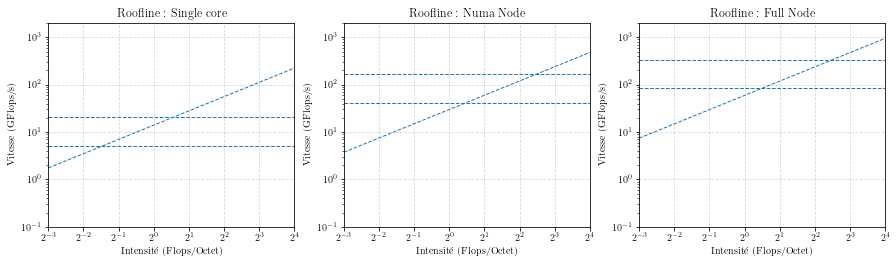

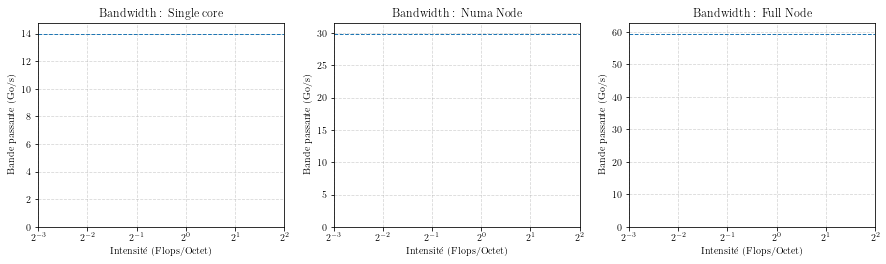

In [4]:
nb_threads=list_threads

titles_threads = {nb_threads[0]:"Single core", nb_threads[1]:"Numa Node", nb_threads[2]:"Full Node"}
bandwidth = { nb_threads[0]:14.0, nb_threads[1]:29.9, nb_threads[2]:59.5}
peak = { nb_threads[0]:20.8, nb_threads[1]:166.4, nb_threads[2]:332.8}


def plot_roofline(threads):
    line = plt.axhline(y=peak[threads], linestyle='dashed', linewidth=1)
    Is = np.array([1./8,16])
    plt.axhline(y=peak[threads]/4, linestyle='dashed', linewidth=1, color=line.get_color())
    plt.plot( Is, Is*bandwidth[threads], linestyle='dashed', linewidth=1, color=line.get_color() )
    plt.xlabel( "Intensité (Flops/Octet)" )
    plt.ylabel( "Vitesse (GFlops/s)" )
    plt.xscale('log',basex=2)
    plt.yscale('log')
    plt.ylim([0.1,2000])
    plt.xlim(Is)

i=1
plt.figure(figsize=(textwidth,figheight))
for threads in titles_threads.keys():
    plt.subplot(1, 3, i).title.set_text("Roofline : " + titles_threads[threads])
    plot_roofline(threads)
    i=i+1

plt.show()

def plot_bandwidth(threads):
    plt.axhline(y=bandwidth[threads], linestyle='dashed', linewidth=1)
    plt.xlabel( "Intensité (Flops/Octet)" )
    plt.ylabel( "Bande passante (Go/s)" )
    plt.xscale('log',basex=2)
    #plt.yscale('log')
    plt.ylim(0)
    Is = np.array([1./8,4])
    plt.xlim(Is)
i=1
plt.figure(figsize=(textwidth,figheight))
for threads in titles_threads.keys():
    plt.subplot(1, 3, i).title.set_text("Bandwidth : " + titles_threads[threads])
    plot_bandwidth(threads)
    i=i+1

plt.show()


### Mesures structure de données

#### Roofline

Le roofline model donne un apercu de l'efficacité du parcours des stuctures de données en affichant la performance maximale atteignable et en placant la performance mesurée sur un graphique.

Les performances sont calculées sur la base des Flops utiles executées lors d'un parcours.

In [5]:
nb_proc=1
rank=0

#list_sizes = ['1e+05', '1e+06']
list_names_nompi = ["Stream", "Nodes", "Segs with Nodes", "Nodes with Segs"]

def plot_roofline_perf( threads, size ):
    for name in list_names_nompi:
        intensities = flops_count[size,nb_proc]/loadstore_size[size,nb_proc]
        Gflopss = (flops_count[size,nb_proc]/res_matrix[nb_proc,rank,threads,size,name])*1000
        plt.plot( intensities, Gflopss, 'd-', label=name, linewidth=1 )
    plot_roofline(threads)
    plt.legend(loc=4) 


for threads in list_threads:
    i=1
    plt.suptitle("Roofline : " + titles_threads[threads])
    for size in list_sizes:        
        subplt = plt.subplot(1, 2, i).title.set_text(size+" Elements ")
        plot_roofline_perf(threads, size) 
        i=i+1
    plt.show()

KeyError: (1, 0, 1, '1e+06', 'Nodes with Segs')

Les différents algorithmes :
 * Les performances de stream et Nodes sont très similaires : il n'y a pas d'accès irréguliers dans Nodes.
 * 'Segs with nodes' et 'nodes with segs' ont des performances moins bonnes à cause des accès irréguliers.
 * 'nodes with segs' en derniers : on ne sais pas combien de segments sont connectés a l'avance
 
Dans la partie memory-bound : 
* effets de cache à 1e5
* Moins bonne performance avec la structure en numa
* plus détails par la suite

Dans la partie compute-bound :
* Seul stream dépasse vraiment la perf max sans vecto

#### Bande passante

Les graphiques de bande passante permettent de mieux voir les valeurs mesurées dans la partie memory-bound du roofline model

In [ ]:
nb_proc=1

def plot_bandwidth_perf( threads, size ) :
    for name in list_names_nompi:
        intensities = flops_count[size,nb_proc]/loadstore_size[size,nb_proc]
        GBps = (loadstore_size[size,nb_proc]/res_matrix[nb_proc,rank,threads,size,name])*1000
        plt.plot( intensities, GBps, 'd-', label=name, linewidth=1 )
    plot_bandwidth(threads)
    plt.legend(loc=1) 

for threads in list_threads:
    i=1
    plt.suptitle("Bande passante : " + titles_threads[threads])
    for size in list_sizes:        
        plt.subplot(1, 2, i).title.set_text(size+" Elements ")
        plot_bandwidth_perf( threads, size )     
        i=i+1
    plt.show()

* On observe encore des effets de cache en 1e5
* On remarque que les fonctions de parcours du Mesh ne sont pas efficaces en NUMA : Stream est bien meilleur

#### Comportement en fonction de la taille

Lorsque les tableaux tiennent en cache on observe de effets de cache : la bande passante dans la partie gauche du graphe dépasse la bande passante RAM. Cependant, c'est un cas qui apparait rarement dans optidis car on utilise souvent des tableaux différents (pas en cache).

Pour des tailles plus grandes, on observe que la bande passante sur un noeud numa est proche de la bande passante max.

La taille n'infuence pas l'efficacité en compute-bound

In [ ]:
!mkdir fig

plt.figure(figsize=(0.33*textwidth, figheight))
plot_roofline_perf(8,'1e+05')
plt.savefig("fig/roofline_1e5_numa.pdf")
plt.legend(loc=1)
plt.show()

plt.figure(figsize=(0.33*textwidth, figheight))
plot_bandwidth_perf(8,'1e+05')
plt.savefig("fig/bandwidth_1e5_numa.pdf")
plt.show()

plt.figure(figsize=(0.33*textwidth, figheight))
plot_roofline_perf(8,'1e+06')
plt.savefig("fig/roofline_1e6_numa.pdf")
plt.legend(loc=1)
plt.show()

plt.figure(figsize=(0.33*textwidth, figheight))
plot_bandwidth_perf(8,'1e+06')
plt.savefig("fig/bandwidth_1e6_numa.pdf")
plt.show()

#### Comportement en fonction du nombre de threads

La structure de données n'est pas adaptée aux architectures NUMA : on préferera faire tourner un processus MPI par noeud NUMA.

In [ ]:
plt.figure(figsize=(0.33*textwidth, figheight))
plot_bandwidth_perf(8,'1e+06')
plt.savefig("fig/bandwidth_1e6_numa.pdf")
plt.show()

plt.figure(figsize=(0.33*textwidth, figheight))
plot_bandwidth_perf(16,'1e+06')
plt.savefig("fig/bandwidth_1e6_fullnode.pdf")
plt.show()

plt.figure(figsize=(0.33*textwidth, figheight))
plot_roofline_perf(8,'1e+06')
plt.savefig("fig/roofline_1e6_numa.pdf")
plt.show()

plt.figure(figsize=(0.33*textwidth, figheight))
plot_roofline_perf(16,'1e+06')
plt.savefig("fig/roofline_1e6_fullnode.pdf")
plt.show()

## Benchmarks MPI

In [6]:
threads=8
intensities=[0,3,9]
list_sizes_mpi = ['1e+05', '1e+06']

nb_procs = np.array(list_nb_procs)

times_max={}
times_min={}
for size in list_sizes_mpi:        
    for name in list_names:
        for intensity in intensities:
            times_max[size,name,intensity] = [ max([ res_matrix[p,rank,threads,size,name][intensity] for rank in range(p) ]) for p in nb_procs ]
            times_min[size,name,intensity] = [ min([ res_matrix[p,rank,threads,size,name][intensity] for rank in range(p) ]) for p in nb_procs ]
intensity_val={}
for intensity in intensities:
    intensity_val[intensity] = flops_count['1e+05',1][intensity]/loadstore_size['1e+05',1][intensity]

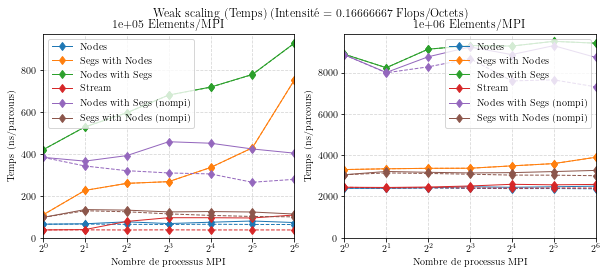

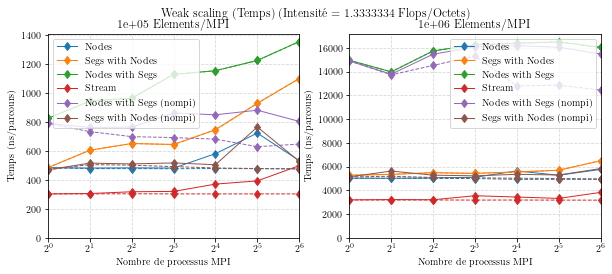

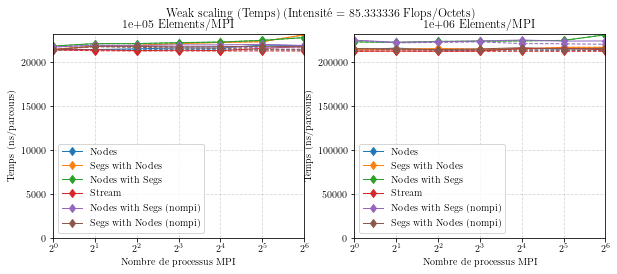

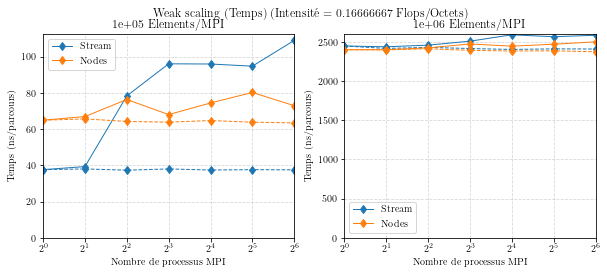

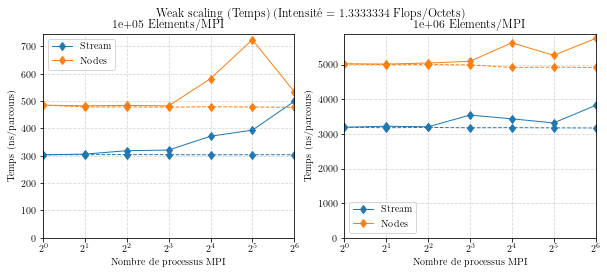

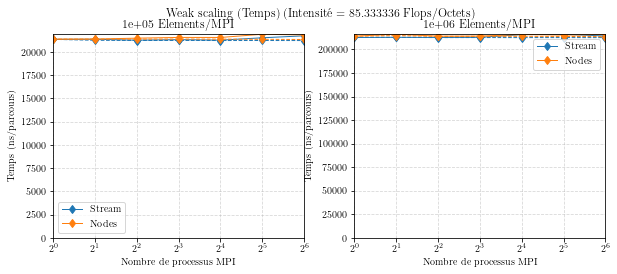

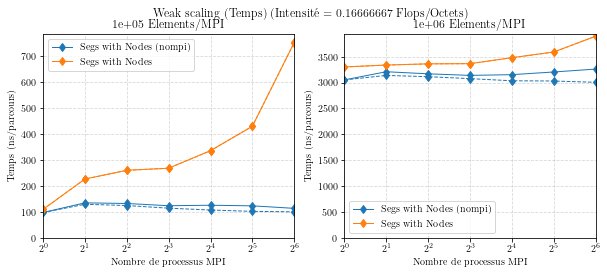

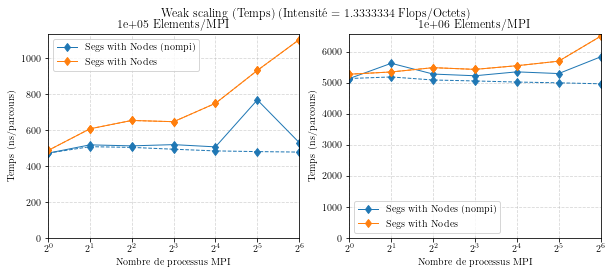

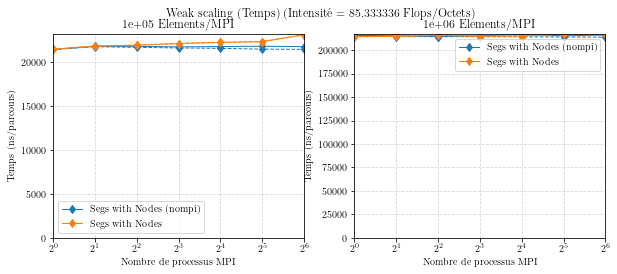

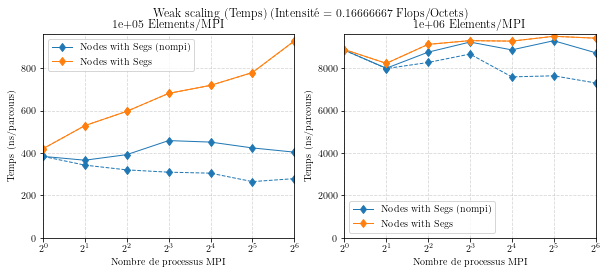

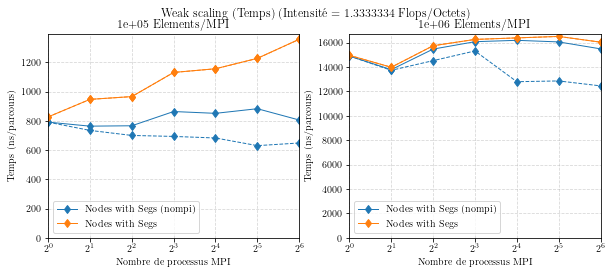

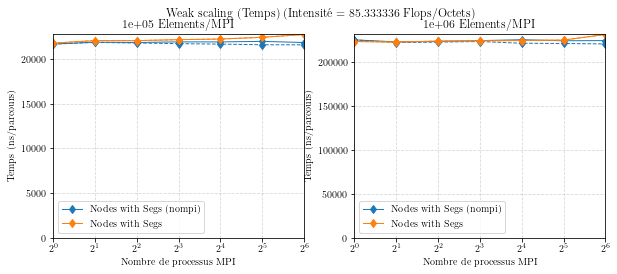

In [8]:
filter_names = [
    list_names,
    ['Stream', 'Nodes'],
    ['Segs with Nodes (nompi)', 'Segs with Nodes'],
    ['Nodes with Segs (nompi)', 'Nodes with Segs'],
]

for list_names_filtered in filter_names:
    for intensity in intensities:
        i=1
        fig,ax=plt.subplots()
        plt.suptitle("Weak scaling (Temps) (Intensité = "+str(intensity_val[intensity])+" Flops/Octets)")
        for size in list_sizes_mpi:        
            plt.subplot(1, 2, i).title.set_text(size+" Elements/MPI")
            for name in list_names_filtered:
                nb_procs = np.array(list_nb_procs)
                line, = plt.plot( nb_procs, times_max[size,name,intensity],'d-', label=name, linewidth=1 )
                plt.plot( nb_procs, times_min[size,name,intensity],'d--', linewidth=1, color=line.get_color())
            plt.xscale('log',basex=2)
            ax.set_xticks(nb_procs)
            plt.xlim([1,64])
            plt.ylim(0)
            plt.ylabel("Temps (ns/parcours)")
            plt.xlabel("Nombre de processus MPI")
            plt.legend()        
            i=i+1
        plt.show()

Dans les graphes précédents, la ligne pleine représente le temps maximum, et les pointillés le temps minimum. Des pointillés non-confondus avec la ligne pleine indiquent une différence de charge entre les différents processus.

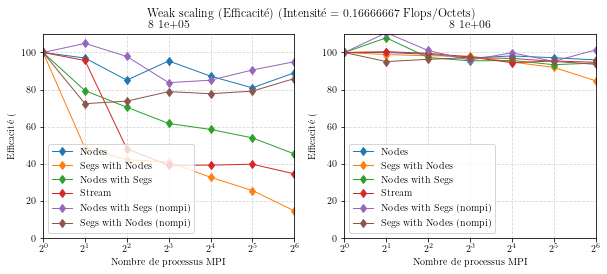

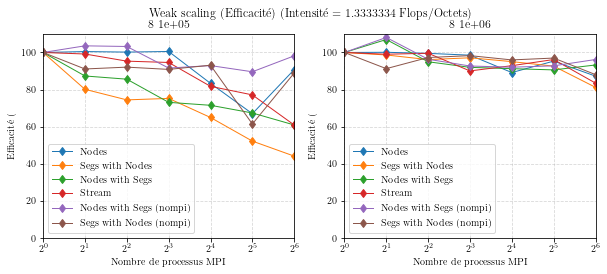

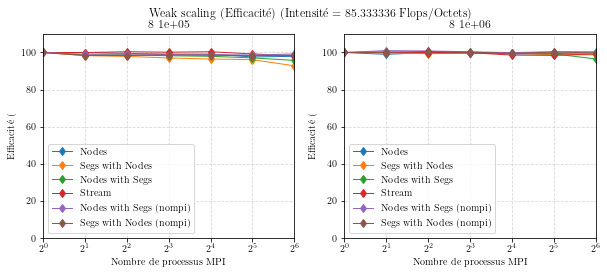

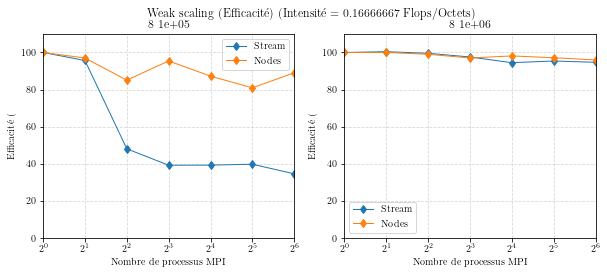

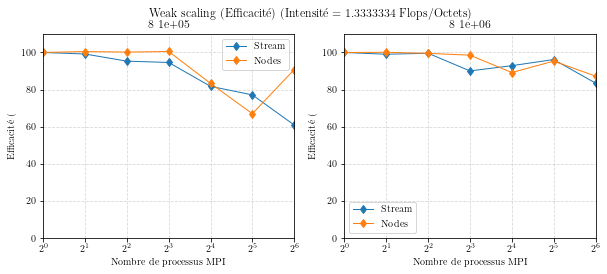

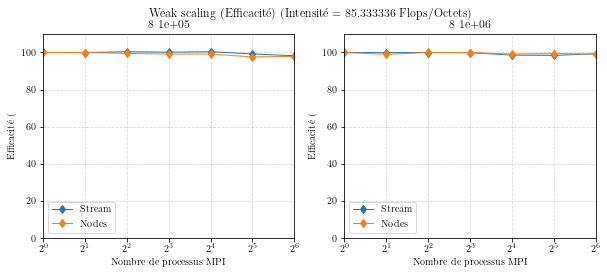

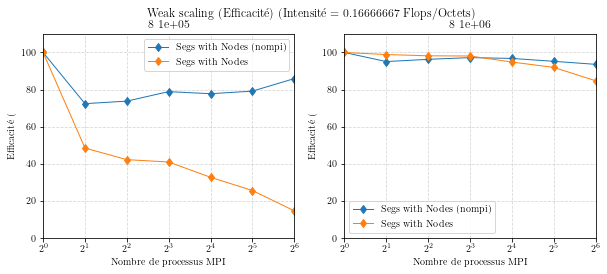

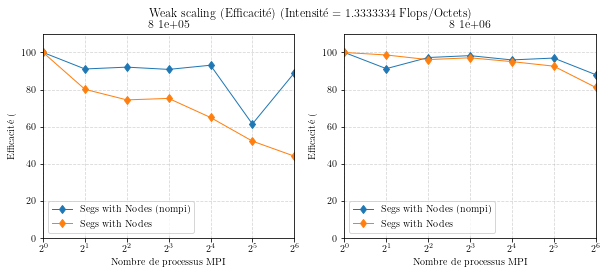

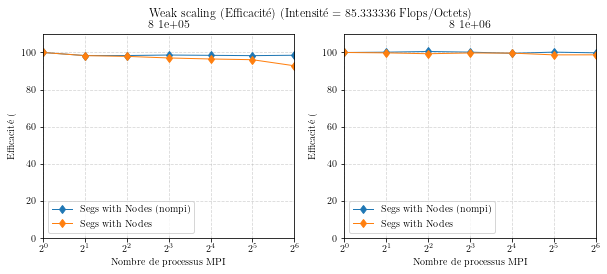

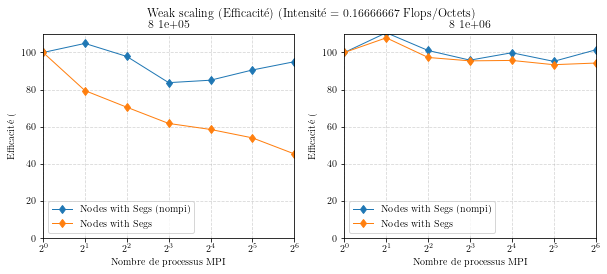

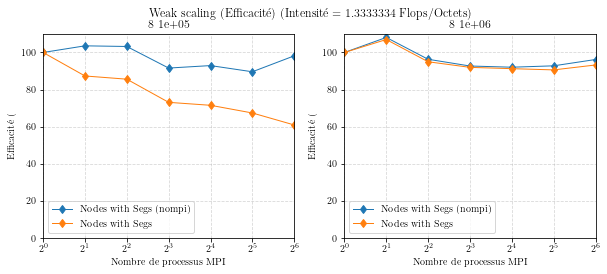

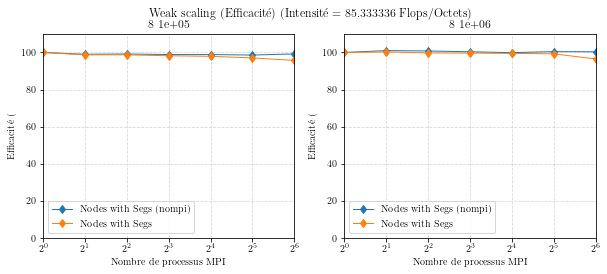

In [9]:
for list_names_filtered in filter_names:
    for intensity in intensities:
        i=1
        plt.suptitle("Weak scaling (Efficacité) (Intensité = "+str(intensity_val[intensity])+" Flops/Octets)")
        for size in list_sizes_mpi:        
            plt.subplot(1, 2, i).title.set_text(size+" Elements/MPI")
            for name in list_names_filtered:
                #plt.axhline(y=100, linestyle='dashed', linewidth=1)
                plt.plot( nb_procs, times_max[size,name,intensity][0]/times_max[size,name,intensity]*100, 'd-', label=name, linewidth=1 )
            plt.xscale('log',basex=2)
            plt.xlim([1,64])
            plt.ylim([0,110])
            plt.ylabel("Efficacité (%)")
            plt.xlabel("Nombre de processus MPI")
            #plt.ylim([0,110])
            plt.legend()
            plt.title(str(threads)+" "+size)
            i=i+1
        plt.show()